#### traits
The RWKV model presents a novel architecture that combines the strengths of RNNs and Transformers, addressing their respective limitations. 

- This model achieves linear computational and memory complexity during inference, a significant improvement over the quadratic complexity of standard Transformers. （为什么）
- RWKV incorporates a **linear attention mechanism**, allowing it to function as both a Transformer and an RNN, thus harnessing the benefits of **parallelizable training** and **efficient inference**. 
- The architecture includes elements like the **Receptance vector, Weight, Key, and Value vectors**, which interact in a unique, multiplicative manner.
-  RWKV’s design overcomes the challenges of memory bottlenecks and scalability issues associated with Transformers, making it a promising model for large-scale applications and efficient AI development.

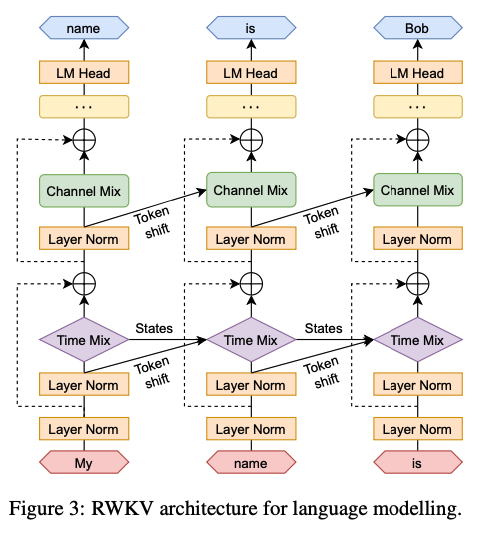

- R（eceptance）：过去信息接受程度
- W（eight）：位置权重衰减向量，可训练的模型参数
- K（ey）：键向量，用每个token自身的键向量来对位置权重衰减向量进行调制，类似传统注意力机制的K
- V（alue）：类似传统注意力机制的V


- time mixing: 将过去的信息加到自己身上来
- channel mixing: 对每个token之间的channel(hidden state)进行一个混合。增强非线性能力

#### Aadvantages
1. Computational Efficiency: RWKV exhibits consistent computational and memory complexity during inference, effectively addressing the resource-intensive nature of traditional Transformers.
计算效率：RWKV在推理过程中具有稳定的计算和内存复杂度，有效解决了传统Transformer资源密集型的特性。
实现了线性注意力的RNN

2. Scalability: The architecture of RWKV is inherently scalable, making it well-suited for large-scale models, a domain where traditional Transformers often face resource constraints.
可扩展性：RWKV的架构具有内在的可扩展性，使其非常适合大规模模型，而传统Transformer通常在资源方面存在限制。RWKV可以在端侧运行。

3. Balanced Performance: RWKV integrates the computational efficiency of RNNs with the parallel processing strength of Transformers, offering a balanced solution that ensures high performance with reduced computational demands.
均衡性能：RWKV将RNN的计算效率与Transformer的并行处理能力相结合，提供一种均衡的解决方案，在降低计算需求的同时确保高性能。
实现了高效的并行训练和高效的串行推理

#### limitations
- RWKV 的线性注意力虽然带来了显著的效率提升，但也可能限制了模型在非常长的上下文中回忆细节的能力。相比标准 Transformer 的二次注意力所保持的全部信息，RWKV 通过单个向量表示在时间上进行信息传递。相对于传统的自注意力机制，模型的循环架构本质上限制了其“回溯”之前信息的能力。虽然时间衰减有助于防止信息丢失，但与完全的自注意力机制相比，它在机制上存在一定的限制。

- 与标准 Transformer 模型相比，prompt engineering 的重要性增加了。RWKV 中的线性注意力机制限制了 prompt 的信息传递。因此，精心设计 prompt 可能对模型在任务上的表现更加关键


- 生成长度为T的序列，RWKV只需要 $O(T)$ 的时间复杂度，transformer是 $O(T^2)$ 
- 生成长度为T的序列，RWKV只需要 $O(d)$ 的空间复杂度，transformer是 $O(T^2 + Td)$ 空间复杂度

![jupyter](/Users/zhangxiaoyu/WorkSpace/rl/model_architecture/images/rwkv-1.png)


![jupyter](/Users/zhangxiaoyu/WorkSpace/rl/model_architecture/images/rwkv-2.png)


In [4]:
########################################################################################################
# The RWKV Language Model - https://github.com/BlinkDL/RWKV-LM
########################################################################################################

import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=200)
import types, torch
from torch.nn import functional as F
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("/Users/zhangxiaoyu/WorkSpace/rl/model_architecture/rwkv/20B_tokenizer.json")

args = types.SimpleNamespace()
args.MODEL_NAME = '/Users/zhangxiaoyu/WorkSpace/rl/model_architecture/rwkv/RWKV-4-Pile-430M-20220808-8066'
args.n_layer = 24
args.n_embd = 1024

context = "\nIn a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet. Even more surprising to the researchers was the fact that the dragons spoke perfect Chinese."
NUM_TRIALS = 3
LENGTH_PER_TRIAL = 100
TEMPERATURE = 1.0
TOP_P = 0.85

########################################################################################################
########################################################################################################

class RWKV_RNN(torch.jit.ScriptModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.eval() # set torch to inference mode
        
        w = torch.load(args.MODEL_NAME + '.pth', map_location='cpu')
        for k in w.keys():
            if      '.time_' in k: w[k] = w[k].squeeze()
            if '.time_decay' in k: w[k] = -torch.exp(w[k].float()) # the real time decay is like e^{-e^x}
            else: w[k] = w[k].float() # convert to f32 type
        
        self.w = types.SimpleNamespace() # set self.w from w
        self.w.blocks = {}
        for k in w.keys(): # example: "blocks.0.att.time_first" => self.w.blocks[0].att.time_first
            parts = k.split('.')
            last = parts.pop()
            here = self.w
            for p in parts:
                if p.isdigit():
                    p = int(p)
                    if p not in here: here[p] = types.SimpleNamespace()
                    here = here[p]
                else:
                    if not hasattr(here, p): setattr(here, p, types.SimpleNamespace())
                    here = getattr(here, p)
            setattr(here, last, w[k])

    def layer_norm(self, x, w):
        return F.layer_norm(x, (self.args.n_embd,), weight=w.weight, bias=w.bias)

    @torch.jit.script_method
    def channel_mixing(self, x, state, i:int, time_mix_k, time_mix_r, kw, vw, rw):
        xk = x * time_mix_k + state[5*i+0] * (1 - time_mix_k)
        xr = x * time_mix_r + state[5*i+0] * (1 - time_mix_r)
        state[5*i+0] = x
        r = torch.sigmoid(rw @ xr)
        k = torch.square(torch.relu(kw @ xk)) # square relu, primer paper
        return r * (vw @ k)

    @torch.jit.script_method
    def time_mixing(self, x, state, i:int, time_mix_k, time_mix_v, time_mix_r, time_first, time_decay, kw, vw, rw, ow):
        """
        x: 公式中的 x_t, 已经经过了layer_norm    ([1024])
        i: 第i层，从0开始. 每一层的state都包含了5个变量
        state: ([120, 1024])
            - state[5*i+1] 指的是 time_mixing 中的 x_t-1
            - state[5*i+2] 指的是 time_mixing 中的 a_t-1（RWKV写成RNN递归形式时的a_t-1参数）
            - state[5*i+3] 指的是 time_mixing 中的 b_t-1（RWKV写成RNN递归形式时的b_t-1参数）
            - state[5*i+4] 用于 time_mixing 中计算wkv的 数值稳定
            - state[5*i+0] 指的是 channel_mixing中的x_t-1

        time_mix_k: 公式中的 miu_k  ([1024])
        time_mix_v: 公式中的 miu_v  ([1024])
        time_mix_r: 公式中的 miu_r  ([1024])
        time_first:  ([1024])
        time_decay:  ([1024])
        kw: 公式中的 W_k 权重矩阵  ([1024, 1024])
        vw: 公式中的 W_v 权重矩阵  ([1024, 1024])
        rw: 公式中的 W_r 权重矩阵  ([1024, 1024])
        ow: 公式中的 W_o 权重矩阵  ([1024, 1024])
        """
        xk = x * time_mix_k + state[5*i+1] * (1 - time_mix_k)  # 
        xv = x * time_mix_v + state[5*i+1] * (1 - time_mix_v)
        xr = x * time_mix_r + state[5*i+1] * (1 - time_mix_r)
        state[5*i+1] = x
        r = torch.sigmoid(rw @ xr)  # sigmoid(r_t)
        k = kw @ xk # k_t
        v = vw @ xv  # v_t
        
        aa = state[5*i+2]
        bb = state[5*i+3]
        pp = state[5*i+4]  # 先前计算的最大值部分，用于数值稳定性
        ww = time_first + k  # time_first对应公式的 miu + k_t 中的 miu
        qq = torch.maximum(pp, ww)  # 这三行代码计算指数部分，用于避免数值下溢或上溢
        e1 = torch.exp(pp - qq)
        e2 = torch.exp(ww - qq)
        a = e1 * aa + e2 * v
        b = e1 * bb + e2
        wkv = a / b

        # 开始更新 aa，bb和pp，留给下一步使用
        ww = pp + time_decay
        qq = torch.maximum(ww, k)
        e1 = torch.exp(ww - qq)
        e2 = torch.exp(k - qq)
        state[5*i+2] = e1 * aa + e2 * v
        state[5*i+3] = e1 * bb + e2
        state[5*i+4] = qq
        return ow @ (r * wkv)

    def forward(self, token, state):
        with torch.no_grad():  # PyTorch 中的一个上下文管理器，它的主要作用是临时关闭自动梯度计算，所有操作都不会被 autograd 记录
            if state == None:
                state = torch.zeros(self.args.n_layer * 5, self.args.n_embd)
                for i in range(self.args.n_layer): state[5*i+4] = -1e30 # -infinity
            
            x = self.w.emb.weight[token]
            x = self.layer_norm(x, self.w.blocks[0].ln0)
            for i in range(self.args.n_layer): # 对每一层都进行同样的操作
                att = self.w.blocks[i].att
                x = x + self.time_mixing(self.layer_norm(x, self.w.blocks[i].ln1), state, i, 
                    att.time_mix_k, att.time_mix_v, att.time_mix_r, att.time_first, att.time_decay, 
                    att.key.weight, att.value.weight, att.receptance.weight, att.output.weight)
                ffn = self.w.blocks[i].ffn
                x = x + self.channel_mixing(self.layer_norm(x, self.w.blocks[i].ln2), state, i, 
                    ffn.time_mix_k, ffn.time_mix_r, 
                    ffn.key.weight, ffn.value.weight, ffn.receptance.weight)
            
            x = self.w.head.weight @ self.layer_norm(x, self.w.ln_out)
            return x.float(), state

##########################################################################################################

def sample_logits(out, temperature=1.0, top_p=0.8):
    probs = F.softmax(out, dim=-1).numpy()
    sorted_probs = np.sort(probs)[::-1]
    cumulative_probs = np.cumsum(sorted_probs)
    cutoff = float(sorted_probs[np.argmax(cumulative_probs > top_p)])
    probs[probs < cutoff] = 0
    if temperature != 1.0:
        probs = probs.pow(1.0 / temperature)
    probs = probs / np.sum(probs)
    out = np.random.choice(a=len(probs), p=probs)
    return out

########################################################################################################

print(f'\nUsing CPU. Loading {args.MODEL_NAME} ...')
model = RWKV_RNN(args)

print(f'\nPreprocessing context (slow version. see v2/rwkv/model.py for fast version)')
init_state = None
for token in tokenizer.encode(context).ids:
    init_out, init_state = model.forward(token, init_state)

for TRIAL in range(NUM_TRIALS):  # NUM_TRIALS 就是epoch
    print(f'\n\n--[ Trial {TRIAL} ]-----------------', context, end="")
    all_tokens = []
    out_last = 0
    out, state = init_out.clone(), init_state.clone()
    for i in range(LENGTH_PER_TRIAL):  # seq_length
        token = sample_logits(out, TEMPERATURE, TOP_P)  # TEMPERATURE, TOP_P，采样的一些设置
        all_tokens += [token]
        tmp = tokenizer.decode(all_tokens[out_last:])
        if '\ufffd' not in tmp: # only print when we have a valid utf-8 string
            print(tmp, end="", flush=True)
            out_last = i + 1
        out, state = model.forward(token, state)       
print('\n')


Using CPU. Loading /Users/zhangxiaoyu/WorkSpace/rl/model_architecture/rwkv/RWKV-4-Pile-430M-20220808-8066 ...

Preprocessing context (slow version. see v2/rwkv/model.py for fast version)


--[ Trial 0 ]----------------- 
In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet. Even more surprising to the researchers was the fact that the dragons spoke perfect Chinese. The Dragon King's wife...

Exclusive on ChinaToday.com. Connect with us on:

Email us at

AsiaNews@NorthChina.com

This news release may contain certain forward-looking statements and information, as defined by applicable securities legislation. All statements, including statements of historical fact, are forward-looking statements. These forward-looking statements include, but are not limited to, the following: the decision to seek Board approval for the proposed Transaction, including

--[ Trial 1 ]----------------- 
In a shocking finding, scientist disco